## Import libraries

In [2]:
import glob
import pandas as pd
import warnings
from tqdm import tqdm
import os
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
import matplotlib.ticker as ticker

## Functions

In [3]:
def get_csv_data_as_dataframe(data_path, Animal_ID, protocol, data_type, unique_value_threshold=10):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
        unique_value_threshold (int): maximum number of unique values to retrieve per column

    Returns:
        multiindex_df (pd.DataFrame): MultiIndex DataFrame containing information for each CSV file
    """

    subject_folders = glob.glob(f"{data_path}/{Animal_ID}/*")
    protocol_folders = [folder for folder in subject_folders if f"{protocol}_{Animal_ID}" in folder]

    if not protocol_folders:
        warnings.warn(f"{Animal_ID}: protocol folders empty")
        return pd.DataFrame()

    data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc=f'Processing {Animal_ID}'):
        folder_files = glob.glob(f"{folder}/**/{data_type}*.csv", recursive=True)
        for file_path in folder_files:
            try:
                df = pd.read_csv(file_path)
                # Check if the DataFrame is empty (only headers, no data rows)
                if df.empty:
                    # If the DataFrame is empty, skip this file and continue with the next one
                    continue
                # Shorten the file path
                short_path = '/'.join(file_path.split('/')[-3:])
                file_size = os.path.getsize(file_path)
                creation_timestamp = os.path.getctime(file_path)
                creation_time_human = datetime.datetime.fromtimestamp(creation_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                num_rows = len(df)
                num_columns = len(df.columns)  # Number of columns in the dataframe

                for column in df.columns:
                    unique_types = df[column].dropna().apply(lambda x: type(x).__name__).unique()[:unique_value_threshold]
                    unique_values = df[column].dropna().unique()[:unique_value_threshold]
                    num_missing = df[column].isnull().sum()
                        # When Info_Type is unique_types and the Data column is empty, fill it with NaN
                    # if 'unique_types' in df['Info_Type'].values and df[column].isnull().all():
                    #     df.loc[df['Info_Type'] == 'unique_types', 'Data'] = np.nan
                    # Calculate summary statistics only for numerical columns
                    if df[column].dtype in [np.int64, np.float64]:
                        summary_stats = df[column].describe().to_dict()
                        column_data = {
                            'unique_types': ', '.join(unique_types),
                            'unique_values': ', '.join(map(str, unique_values)),
                            'num_missing': num_missing,
                            **summary_stats
                        }
                    else:
                        column_data = {
                            'unique_types': ', '.join(unique_types),
                            'unique_values': ', '.join(map(str, unique_values)),
                            'num_missing': num_missing
                        }
                    for info_type, value in column_data.items():
                        data.append((short_path, column, info_type, value))

                # Add file metadata including creation timestamp and number of columns
                data.append((short_path, 'File_Metadata', 'file_size', file_size))
                data.append((short_path, 'File_Metadata', 'num_rows', num_rows))
                data.append((short_path, 'File_Metadata', 'num_columns', num_columns))  # Adding num_columns
                data.append((short_path, 'File_Metadata', 'creation_timestamp', creation_time_human))

            except Exception as e:
                warnings.warn(f"Error processing file {file_path}: {e}")

    # Creating MultiIndex DataFrame
    multiindex_df = pd.DataFrame(data, columns=['File_Path', 'Column', 'Info_Type', 'Data'])
    multiindex_df.set_index(['File_Path', 'Column', 'Info_Type'], inplace=True)

    return multiindex_df

def get_animal_data(data_path, Animal_ID, protocol, data_type):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
    Returns:
        animal_df (pd.DataFrame): dataframe containing all the data for the animal
    """

    subject_folders = glob.glob(data_path + Animal_ID +'/*') 
    protocol_folders = list(filter(lambda x: protocol in x, subject_folders)) 

    if len(protocol_folders) == 0:
        warnings.warn(f"{Animal_ID}: all_folders empty")
        return 0

    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID ):  
        folder_files = glob.glob(folder +'/**/'+data_type +'*.csv', recursive = True)
        for file in folder_files:
            try:
                session_df = pd.read_csv(file)

                # # Explicitly cast columns with all-bool values to boolean type
                # for col in session_df.columns:
                #     if session_df[col].dtype == 'object' and set(session_df[col].unique()) <= {True, False, None}:
                #         session_df[col] = session_df[col].astype('bool')

                date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
                date = re.search(date_pattern, file).group(0)
                date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
                formatted_date = date_obj.strftime('%Y/%m/%d')
                session_df.insert(0, 'Date', formatted_date)
                session_df['File_ID'] = file  # Add file identifier
                sessions_data.append(session_df)
            except pd.errors.EmptyDataError:
                pass

        animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)
        # Create a list of columns for sorting
        sort_columns = ['Date']

        # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
        if 'Trial_End_Time' in animal_df.columns:
            sort_columns.append('Trial_End_Time')
        elif 'Time' in animal_df.columns:
            sort_columns.append('Time')

        # Sort the DataFrame by the determined columns
        animal_df = animal_df.sort_values(by=sort_columns)

        date_list = []
        for date in animal_df.Date.unique():
            date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
            date_list.append(date_df)
            
        animal_df = pd.concat(date_list, axis=0, ignore_index=True)

    return animal_df

## Get CSV Info

In [4]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
              'QP083', 
              # 'QP084', 'QP085', 'QP090', 
              'QP091', 
              'QP092',  
              'QP0104',  
              'QP0105', 
              'QP0106', 
              'QP0107', 
              'QP0108',
              'QP0113',
              # 'QP0115',
              # 'QP0116',
              # 'QP0117',
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_csv_info.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        csv_info = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    csv_info = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_csv_data_as_dataframe(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            csv_info = pd.concat([csv_info, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(csv_info, f)

In [5]:
csv_info_reset = csv_info.reset_index()
# whenever there is a NaN in the Data column and the Info_Type is unique_types, fill it with NaN
csv_info_reset.loc[csv_info_reset['Info_Type'] == 'unique_types', 'Data'] = csv_info_reset.loc[csv_info_reset['Info_Type'] == 'unique_types', 'Data'].replace('', np.nan)
# sace the csv_info_reset to a csv file
# csv_info_reset.to_csv('/Users/quentin/Desktop/HeadFixedBehavior/Data/all_csv_info.csv')

In [6]:
# Break execution at thie cell
raise Exception("Execution stopped")

Exception: Execution stopped

## Breakdown for each column

In [7]:
# Step 1: Identify each unique value in the 'Column' column
unique_columns = csv_info_reset['Column'].unique()

analysis_results = {}

for column in unique_columns:
    column_df = csv_info_reset[csv_info_reset['Column'] == column]
    unique_file_paths_count = column_df['File_Path'].nunique()

    # Breakdown by data type
    data_types = column_df[column_df['Info_Type'] == 'unique_types']['Data'].unique()
    data_types_breakdown = {}
    for data_type in data_types:
        # Start by handling the NaN case
        if pd.isna(data_type):
            data_type_count = column_df[(column_df['Info_Type'] == 'unique_types') & (column_df['Data'].isna())]['File_Path'].nunique()
            data_types_breakdown['nan'] = {
                'count': data_type_count
            }
        elif data_type in ['int', 'float', 'double']:
            # Extract numeric values
            numeric_values = column_df[column_df['Info_Type'] == 'unique_values']['Data']
            # Splitting string of numbers into individual numeric values
            numeric_values = numeric_values.dropna().apply(lambda x: pd.Series(str(x).split(', '))).stack().reset_index(drop=True)
            numeric_values = numeric_values.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
            data_type_count = column_df[(column_df['Info_Type'] == 'unique_types') & (column_df['Data'] == data_type)]['File_Path'].nunique()
            # Descriptive summary
            descriptive_summary = numeric_values.describe()
            # Unique values (up to 10)
            unique_values = numeric_values.unique()[:10]
            data_types_breakdown[data_type] = {
                'count': data_type_count,
                'summary': descriptive_summary,
                'unique_values': unique_values
            }
        else:
            # For non-numeric types, list all unique values
            unique_values = column_df[column_df['Info_Type'] == 'unique_values']['Data'].unique()
            data_type_count = column_df[(column_df['Info_Type'] == 'unique_types') & (column_df['Data'] == data_type)]['File_Path'].nunique()
            data_types_breakdown[data_type] = {
                'count': data_type_count,
                'unique_values': unique_values
            }

    # Add the results to the dictionary
    analysis_results[column] = {
        'unique_file_paths_count': unique_file_paths_count,
        'data_types_breakdown': data_types_breakdown
    }

# Convert the dictionary to a DataFrame for better visualization
analysis_results_df = pd.DataFrame.from_dict(analysis_results, orient='index')
analysis_results_df.reset_index(inplace=True)
analysis_results_df.rename(columns={'index': 'Column'}, inplace=True)

In [8]:
# Interrup execution at this cell
raise Exception("Execution stopped")

Exception: Execution stopped

## Fetch Data

In [9]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
              'QP083', 
              # 'QP084', 'QP085', 'QP090', 
              'QP091', 
              'QP092',  
              'QP0104',  
              'QP0105', 
              'QP0106', 
              'QP0107', 
              'QP0108',
              'QP0113',
              # 'QP0115',
              # 'QP0116',
              # 'QP0117',
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_concat.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_concat = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_concat = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_concat = pd.concat([all_data_concat, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_concat, f)

In [10]:
# Interrup execution at this cell
raise Exception("Execution stopped")

Exception: Execution stopped

In [ ]:
### Breakdown of steps:
# 1. Read all csv files, extremely basic processing (e.g. add Fild_Path tag, add date, etc.) and concatenate together
# 2. Remove nan columns
# 3. Rename all releveant columns
# 4. Remap the values inside those columns
# 5. Check and convert datatypes
# 6. Check ranges (e.g. reject values of choice that are not 0 or 1)
# 7. Deal with missing columns

In [11]:
def remap_values(df, column_info):
    '''
    Remaps values in a dataframe according to the value_mapping dict in column_info
    Args:
        df (pd.DataFrame): dataframe to be remapped
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): remapped dataframe
    '''
    for col, info in column_info.items():
        if col in df.columns and info['value_mapping']:
            for new_val, old_vals in info['value_mapping'].items():
                df[col] = df[col].replace(old_vals, new_val)
    return df

def check_and_convert_dtypes(df, column_info):
    '''
    Checks if the dtypes of the columns in the dataframe match the expected dtypes in column_info
    and converts them if necessary
    Args:
        df (pd.DataFrame): dataframe to be checked
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): dataframe with converted dtypes
    '''
    for col, info in column_info.items():
        if col in df.columns:
            expected_dtype = info['dtype']
            if df[col].dtype != expected_dtype:
                try:
                    df[col] = df[col].astype(expected_dtype)
                except ValueError:
                    print(f"Warning: Could not convert column {col} to {expected_dtype}")
    return df

def standardize_dataframe(df, column_info):
    '''
    Standardizes the dataframe by renaming columns, filtering columns, remapping values and converting dtypes
    If certain columns are missing, they are added (potentially future arguments to choose whether to add them or not)
    Args:
        df (pd.DataFrame): dataframe to be standardized
        column_info (dict): dictionary containing information about the columns
    Returns:
        cleaned_df (pd.DataFrame): standardized dataframe
    '''
    rename_dict = {old_name: new_name for new_name, info in column_info.items() if info['rename'] for old_name in info['rename']}

    cleaned_df_list = []

    # look through all File_IDs and re-index the 'Trial' column, then re-assign the df
    for file_id in df['File_ID'].unique():
        file_df = df[df['File_ID'] == file_id]
        # drop all columns that are fully NaN
        file_df = file_df.dropna(axis=1, how='all')
        # rename columns
        file_df = file_df.rename(columns=rename_dict)

        # remap values
        file_df = remap_values(file_df, column_info)

        file_df = check_and_convert_dtypes(file_df, column_info)

        # re-index the 'Trial' column
        file_df['Trial'] = file_df['Trial'].rank(method='dense').astype('Int64')
        # # Special handling for the 'choice' column
        # if 'choice' in file_df.columns and 2 in file_df['choice'].values:
        #     file_df['choice'] = file_df['choice'] - 1

        # # if 'trial_outcome' is missing, add it
        # if 'Trial_Outcome' not in file_df.columns:
        #     # check if 'correct' and 'no_response' are present
        #     if 'correct' in file_df.columns and 'no_response' in file_df.columns:

        #         file_df.loc[(file_df['correct'] == 1) & ~file_df['no_response'], 'Trial_Outcome'] = 'Correct'
        #         file_df.loc[(file_df['correct'] == 0) & ~file_df['no_response'], 'Trial_Outcome'] = 'Incorrect'
        #         file_df.loc[file_df['no_response'], 'Trial_Outcome'] = 'No_Response'
        #         file_df['Trial_Outcome'].fillna('Unknown', inplace=True)

        # if 'Stim_Relative' not in file_df.columns and 'WN_Amp' in file_df.columns:
        #     file_df['Stim_Relative'] = file_df['WN_Amp'].apply(lambda x: convert_value(x, 
        #                                                                                original_min=50, original_max=82, 
        #                                                                                new_min=-1, new_max=1))
        # if 'Nb_Of_Stim' not in file_df.columns and file_df['Stage'].iloc[0] != 'Full_Task_Cont':
        #     try:
        #         file_df['Nb_Of_Stim'] = len(file_df.Stim_Relative.unique()) 
        #     except AttributeError:
        #         file_df['Nb_Of_Stim'] = np.nan
 
        # only keep columns that are in the column_info dict
        file_df = file_df[[col for col in file_df.columns if col in column_info]]

        cleaned_df_list.append(file_df)

        

    cleaned_df = pd.concat(cleaned_df_list, ignore_index=True)
    return cleaned_df

def convert_value(original_value, original_min=50, original_max=82, new_min=-1, new_max=1):
    # Translate original_value to the new range
    return (original_value - original_min) * (new_max - new_min) / (original_max - original_min) + new_min

def get_col_info(df, column):
    '''
    Returns the column information for a given column
    Args:
        df (pd.DataFrame): dataframe containing the column
        column (str): column name
    Returns:
        result (dict): dictionary containing the column information
    '''
    result = df[df['Column'] == column].data_types_breakdown.iloc[0]
    return result

In [12]:
PA_column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation', 'Stage_1'],
                                  'Lick_To_Release': [2, 'Lick_To_Release', 'Stage_2'],
                                  'Three_And_Three': [3, 'Three_And_Three', 'Stage_3'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc', 'Stage_4'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont', 'Stage_5']}},
    'Trial': {'dtype': 'Int64',
              'rename': ['TrialNumber', 'Trial_Number'],
              'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick', 'First_Lick'], 
               'value_mapping': {0: 'Left', 1: 'Right'}},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'no_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': None,
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': None,
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                'rename': None,
                'value_mapping': None},
    'Air_Puff_Contingency': {'dtype': str,
                             'rename': ['Trial_State'],
                             'value_mapping': {'Pro': [0],
                                                    'Anti': [1]}},
    'Air_Puff_Side': {'dtype': 'Int64', 
                      'rename': ['AirPuff_Side'],
                      'value_mapping': {1: [1, 1.0, 'Right', '1', '1.0'], 
                                        0: [0, 0.0, 'Left', '0', '0.0']}},
    'WN_Amp': {'dtype': float,
                'rename': None,
                'value_mapping': None},
                                            
}

In [13]:
pa_df = standardize_dataframe(all_data_concat, PA_column_info)

In [14]:
# check caolumn outputs align with expected outputs

# where choice is not 0 or 1, set it to NaN
pa_df.loc[~pa_df.choice.isin([0, 1]), 'choice'] = np.nan
# where correct is not 0 or 1, set it to NaN
pa_df.loc[~pa_df.correct.isin([0, 1]), 'correct'] = np.nan
# where Trial_Outcome is not 'Correct', 'Incorrect' or 'No_Response', set it to NaN
pa_df.loc[~pa_df.Trial_Outcome.isin(['Correct', 'Incorrect', 'No_Response']), 'Trial_Outcome'] = np.nan
# where Air_Puff_Side is not 0 or 1, set it to NaN
pa_df.loc[~pa_df.Air_Puff_Side.isin([0, 1]), 'Air_Puff_Side'] = np.nan
# where Air_Puff_Contingency is not 'Pro' or 'Anti', set it to NaN
pa_df.loc[~pa_df.Air_Puff_Contingency.isin(['Pro', 'Anti']), 'Air_Puff_Contingency'] = np.nan
# where Stage is not 'Habituation', 'Lick_To_Release', 'Three_And_Three', 'Full_Task_Disc' or 'Full_Task_Cont', set it to NaN
pa_df.loc[~pa_df.Stage.isin(['Habituation', 'Lick_To_Release', 'Three_And_Three', 'Full_Task_Disc', 'Full_Task_Cont']), 'Stage'] = np.nan
# where Protocol is not 'PRO_ANTI', set it to NaN
pa_df.loc[~pa_df.Protocol.isin(['PRO_ANTI']), 'Protocol'] = np.nan
# where Sound_Contingency is not 'Low_Left_High_Right' or 'Low_Right_High_Left', set it to NaN
pa_df.loc[~pa_df.Sound_Contingency.isin(['Low_Left_High_Right', 'Low_Right_High_Left']), 'Sound_Contingency'] = np.nan
# where Stim_Type is not 'WN' or 'PT', set it to NaN
pa_df.loc[~pa_df.Stim_Type.isin(['WN', 'PT']), 'Stim_Type'] = np.nan
# if Distribution is not 'Uniform', 'Asym_Left' or 'Asym_Right', set it to NaN
pa_df.loc[~pa_df.Distribution.isin(['Uniform', 'Asym_Left', 'Asym_Right']), 'Distribution'] = np.nan

In [15]:
# dealing with missing values
cleaned_df_list = []

for file_id in pa_df.File_ID.unique():
    file_df = pa_df[pa_df['File_ID'] == file_id].reset_index(drop=True)

    if 'Trial_Outcome' not in file_df.columns:
        # check if 'correct' and 'no_response' are present
        if 'correct' in file_df.columns and 'no_response' in file_df.columns:
            file_df.loc[(file_df['correct'] == 1) & ~file_df['no_response'], 'Trial_Outcome'] = 'Correct'
            file_df.loc[(file_df['correct'] == 0) & ~file_df['no_response'], 'Trial_Outcome'] = 'Incorrect'
            file_df.loc[file_df['no_response'], 'Trial_Outcome'] = 'No_Response'
            file_df['Trial_Outcome'].fillna('Unknown', inplace=True)
            
    if 'Nb_Of_Stim' not in file_df.columns and file_df['Stage'].iloc[0] != 'Full_Task_Cont':
        try:
            file_df['Nb_Of_Stim'] = len(file_df.Stim_Relative.unique()) 
        except AttributeError:
            file_df['Nb_Of_Stim'] = np.nan
    if 'Stim_Relative' not in file_df.columns and 'WN_Amp' in file_df.columns:
        file_df['Stim_Relative'] = file_df['WN_Amp'].apply(lambda x: convert_value(x, 
                                                                                   original_min=50, original_max=82, 
                                                                                   new_min=-1, new_max=1))

    cleaned_df_list.append(file_df)

pa_df = pd.concat(cleaned_df_list, ignore_index=True)
# we know the protocol is PRO_ANTI, so we can replace the NaNs in the Protocol column with 'PRO_ANTI'
pa_df.Protocol.fillna('PRO_ANTI', inplace=True)

In [16]:
# TODO: account for extremely large negaticve values in Response_Latency (because of how nans are written in Bonsai)

In [17]:
# Interrup execution at this cell
raise Exception("Execution stopped")

Exception: Execution stopped

QP083


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


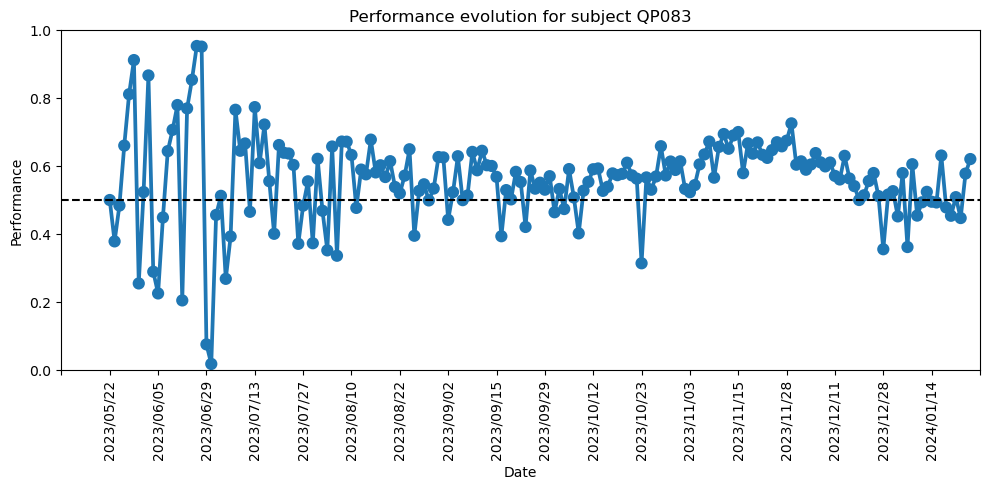

QP091


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


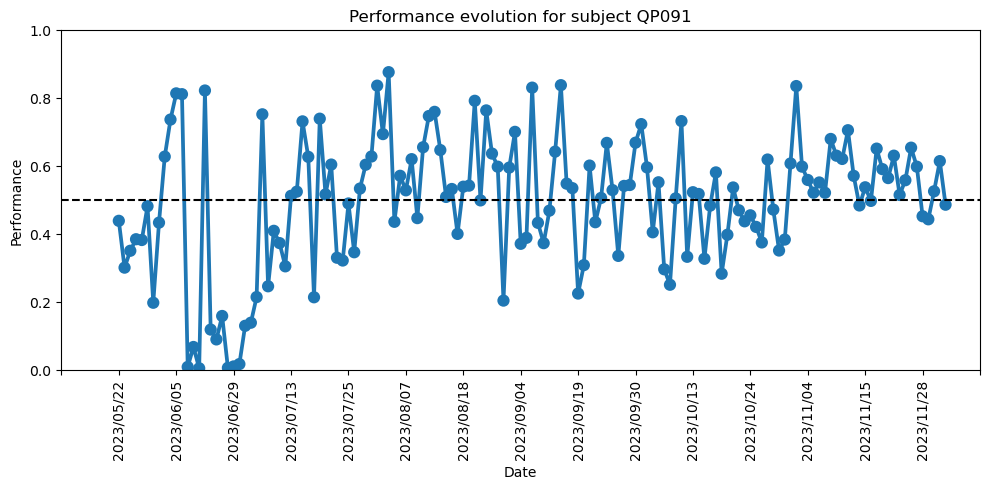

QP092


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


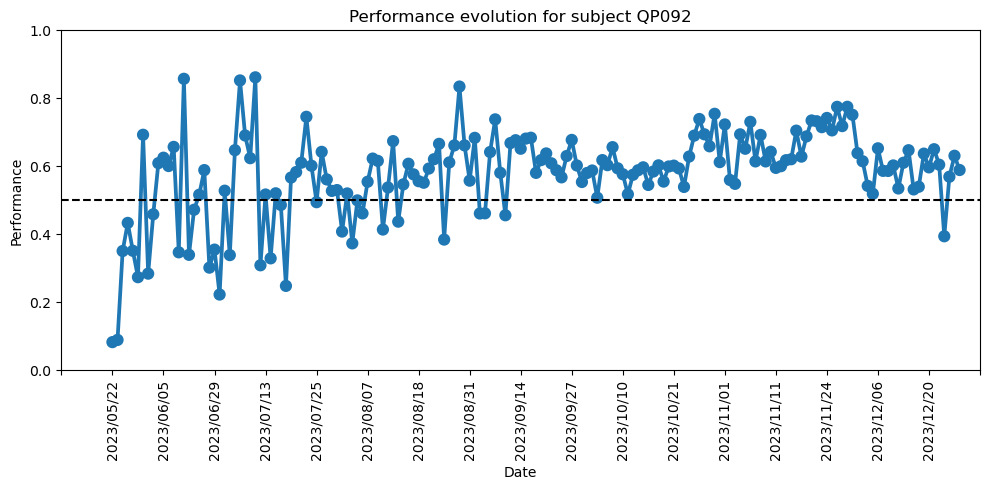

QP0104


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


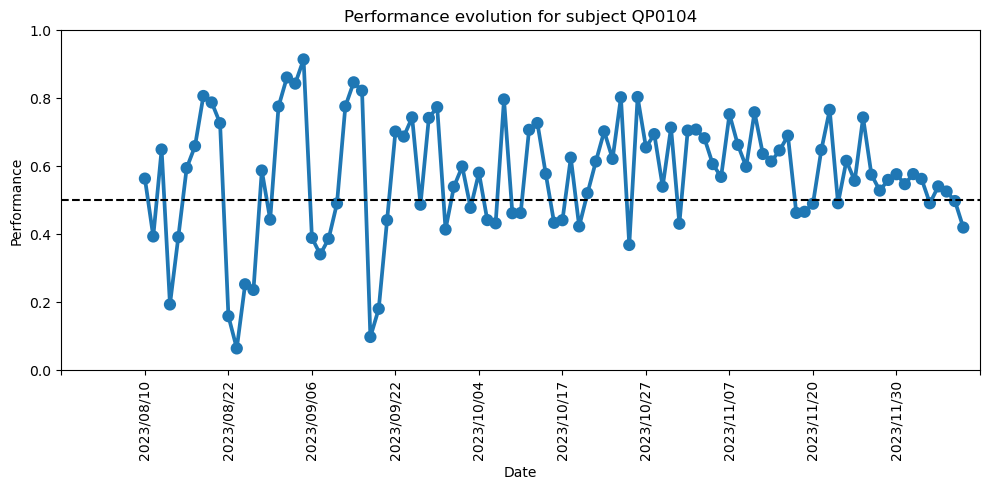

QP0105


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


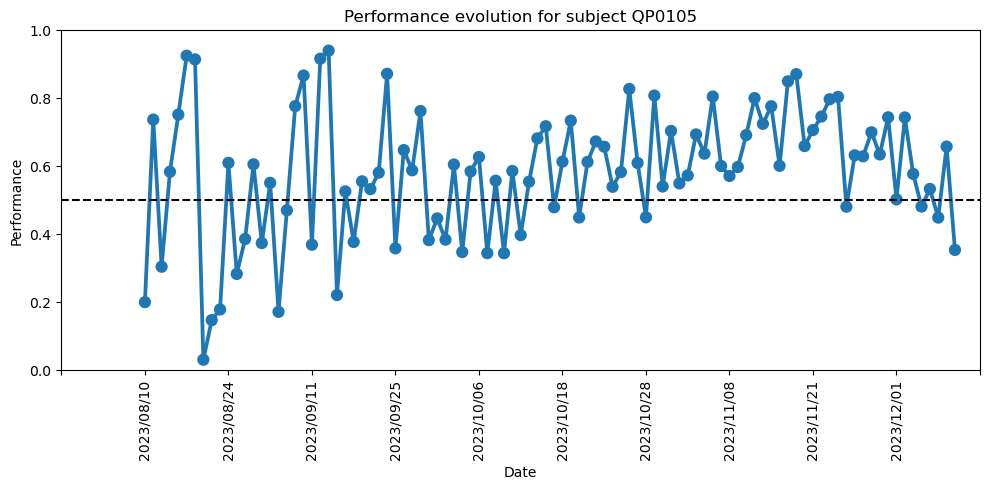

QP0106


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


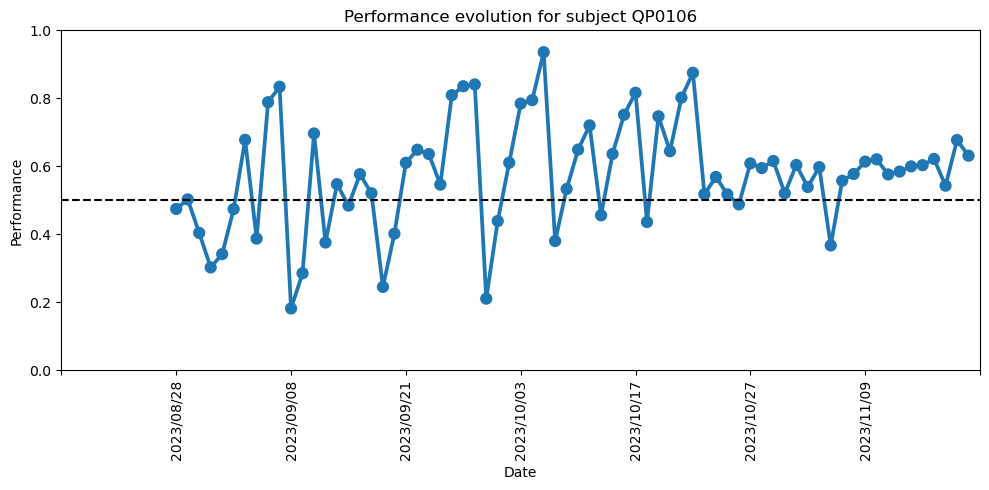

QP0107


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


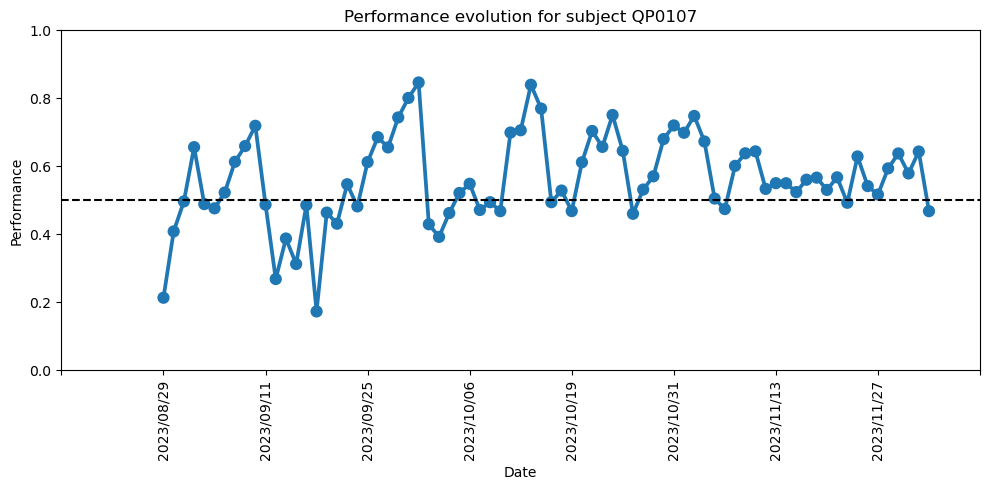

QP0108


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


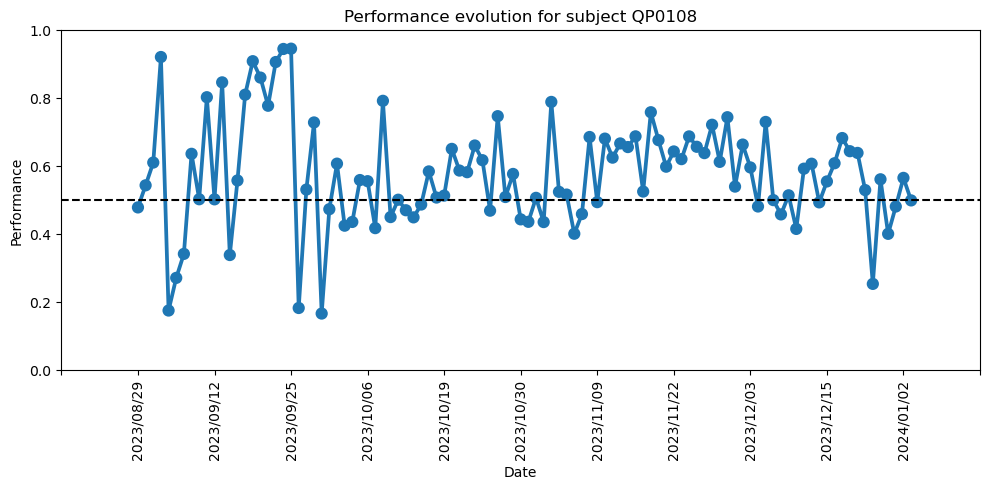

QP0113


/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_21504/2846715899.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)


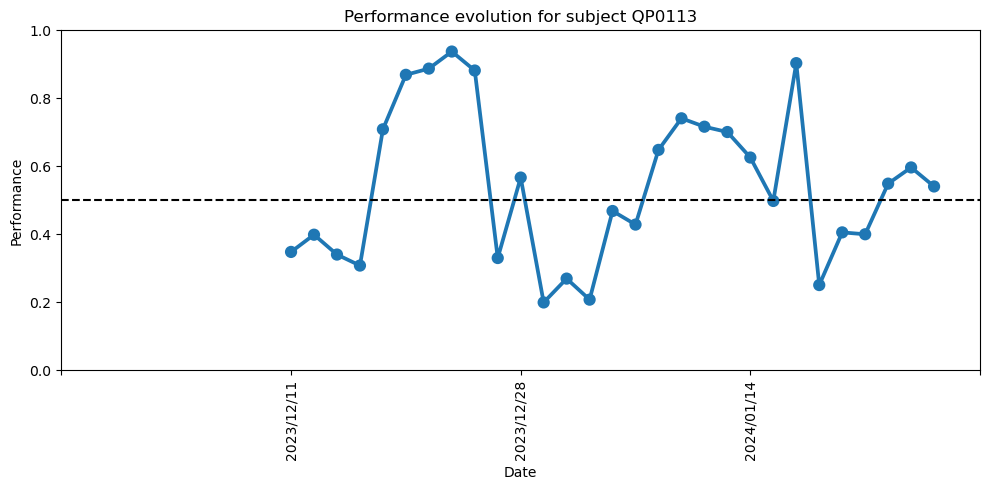

In [18]:
for p_id in pa_df['Participant_ID'].unique():
    print(p_id)
    fig, ax = plt.subplots(figsize=(10, 5))

    participant_df = pa_df[pa_df['Participant_ID'] == p_id].reset_index(drop=True)
    sns.pointplot(data=participant_df[participant_df['Stage'].isin(['Full_Task_Disc', 'Full_Task_Cont'])],# x='Date', y='correct', ax=ax)
                  x='Date', y='correct', ax=ax, ci = None)
    # only show one tick every 10 datea
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    # 90 rotation for the x axis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    # dotted line at 0.5
    ax.axhline(y=0.5, color='black', linestyle='--')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Performance')
    ax.set_xlabel('Date')
    ax.set_title(f'Performance evolution for subject {p_id}')
    plt.tight_layout()
    plt.show()

In [ ]:
participant_df.correct.unique()